In [1]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
os.environ['DDE_BACKEND'] = 'pytorch'

In [2]:
import deepxde as dde 
import torch 
import numpy as np
import matplotlib.pyplot as plt

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.
/userhome/jeon_mg/miniforge3/envs/pinn_torch/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392020201/work/torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


## 1.3 PINN as PDE solver (no data)

### 1.3.1 Define Parameters

In [3]:
E = 50
nu = 0.3
a = 10
b = 10
f = 1
h = 1

### 1.3.2 Define PDE with Boundary Conditions

In [4]:
def pde(X, Y):
    du_xx = dde.grad.hessian(Y, X, component=0, i=0, j=0)
    du_yy = dde.grad.hessian(Y, X, component=0, i=1, j=1)
    du_xy = dde.grad.hessian(Y, X, component=0, i=0, j=1)

    dv_xx = dde.grad.hessian(Y, X, component=1, i=0, j=0)
    dv_yy = dde.grad.hessian(Y, X, component=1, i=1, j=1)
    dv_xy = dde.grad.hessian(Y, X, component=1, i=0, j=1)

    force_eq_x = (du_xx + 0.5*(1-nu)*du_yy + 0.5*(1+nu)*dv_xy)*E/(1-nu**2)
    force_eq_y = (dv_yy + 0.5*(1-nu)*dv_xx + 0.5*(1+nu)*du_xy)*E/(1-nu**2)

    return [force_eq_x, force_eq_y]

In [5]:
def boundary_x(X, on_boundary):
    return on_boundary and np.isclose(X[0], a)

def boundary_y(X, on_boundary):
    return on_boundary and np.isclose(X[1], b)

def boundary_x0(X, on_boundary):
    return on_boundary and np.isclose(X[0], 0)

def boundary_y0(X, on_boundary):
    return on_boundary and np.isclose(X[1], 0)

def BC_xy(X, Y):
    du_x = dde.grad.jacobian(Y, X, i=0, j=0)
    du_y = dde.grad.jacobian(Y, X, i=0, j=1)
    dv_x = dde.grad.jacobian(Y, X, i=1, j=0)
    dv_y = dde.grad.jacobian(Y, X, i=1, j=1)

    sig_xx = (du_x + nu*dv_y)*E/(1-nu**2)
    sig_yy = (dv_y + nu*du_x)*E/(1-nu**2)
    sig_xy = (dv_x + du_y)*E/(1+nu)/2

    sig_ex = f * h * torch.cos(np.pi / (2 * b) * X[:, 1]).reshape(-1, 1)

    return sig_xx-sig_ex, sig_xy, sig_yy

### 1.3.3 Define Geometry and Implement Boundary Conditions

In [6]:
geom = dde.geometry.Rectangle(xmin=[0, 0], xmax=[a, b])

bc_Y0 = dde.DirichletBC(geom, lambda x: 0, boundary_y0, component=1)
bc_X0 = dde.DirichletBC(geom, lambda x: 0, boundary_x0, component=0)

bc_free_yy = dde.OperatorBC(geom, lambda X, Y, _: BC_xy(X, Y)[2], boundary_y)
bc_free_yx = dde.OperatorBC(geom, lambda X, Y, _: BC_xy(X, Y)[1], boundary_y)

bc_traction = dde.OperatorBC(geom, lambda X, Y, _: BC_xy(X, Y)[0], boundary_x)
bc_free_xy = dde.OperatorBC(geom, lambda X, Y, _: BC_xy(X, Y)[1], boundary_x)

In [7]:
data = dde.data.PDE(geom,
                    pde,
                    [bc_Y0, bc_X0, bc_free_yy, bc_free_yx, bc_traction, bc_free_xy],
                    num_domain=9000,
                    num_boundary=1000,
                    num_test=100)

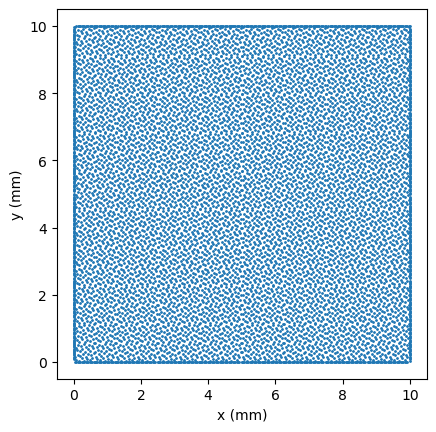

In [8]:
plt.axes().set_aspect('equal')
plt.scatter(data.train_x_all[:, 0], data.train_x_all[:, 1], s=1)
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.show()

### 1.3.4 Define Network and Hyper-parameters

In [9]:
layer_size = [2] + [64] * 5 + [2]
activation = 'tanh'
initializer = 'Glorot uniform'

net = dde.maps.FNN(layer_size, activation, initializer)

In [10]:
model = dde.Model(data, net)

In [11]:
model.compile('adam', lr=1e-3)

Compiling model...
'compile' took 0.560395 s



### 1.3.5 Train (Adam Optimizer)

Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
0         [6.05e-01, 3.15e+00, 2.68e-02, 1.65e-01, 4.44e+00, 1.03e+00, 7.44e-01, 3.54e-01]    [5.75e-01, 2.46e+00, 2.68e-02, 1.65e-01, 4.44e+00, 1.03e+00, 7.44e-01, 3.54e-01]    []  
100       [2.65e-03, 2.17e-03, 4.58e-04, 4.10e-04, 4.03e-05, 4.43e-04, 9.80e-04, 5.83e-04]    [2.45e-03, 1.96e-03, 4.58e-04, 4.10e-04, 4.03e-05, 4.43e-04, 9.80e-04, 5.83e-04]    []  
200       [1.72e-03, 1.11e-03, 1.18e-04, 5.44e-04, 6.60e-05, 1.39e-04, 4.79e-04, 2.73e-04]    [1.53e-03, 9.96e-04, 1.18e-04, 5.44e-04, 6.60e-05, 1.39e-04, 4.79e-04, 2.73e-04]    []  
300       [1.29e-03, 8.38e-04, 2.15e-05, 4.37e-04, 7.25e-05, 1.23e-04, 3.50e-04, 2.41e-04]    [1.11e-03, 7.37e-04, 2.15e-05, 4.37e-04, 7.25e-05, 1.23e-04, 3.50e-04, 2.41e-04]    []  
400       [1.06e-03, 7.01e-04, 6.67e-06, 3.33e-04, 7.20e-05

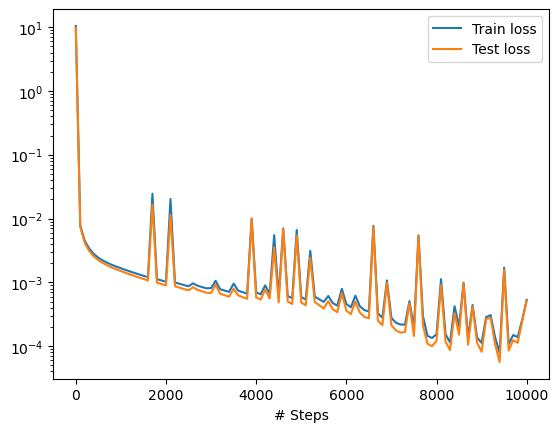

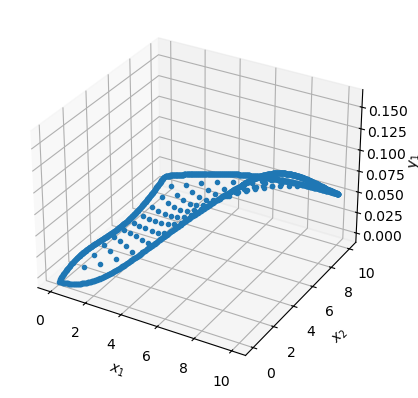

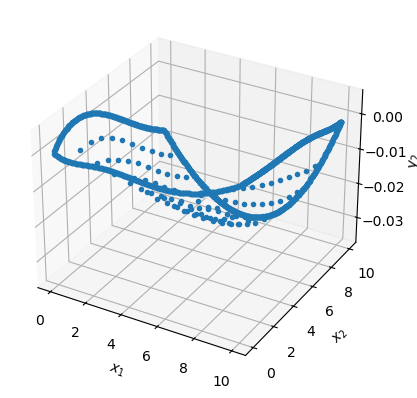

In [12]:
losshistory, train_state = model.train(iterations=10000, display_every=100)
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

### 1.3.6 Plot Displacement (Adam Optimizer)

In [13]:
color_legend = [[0, 0.182], [-0.06, 0.011], [-0.0022, 1.0], [-0.15, 0.45]]
title = ['x-displacement ($u$)', 'y-displacement ($v$)', '$\sigma_{xx}$', '$\sigma_{yy}$']

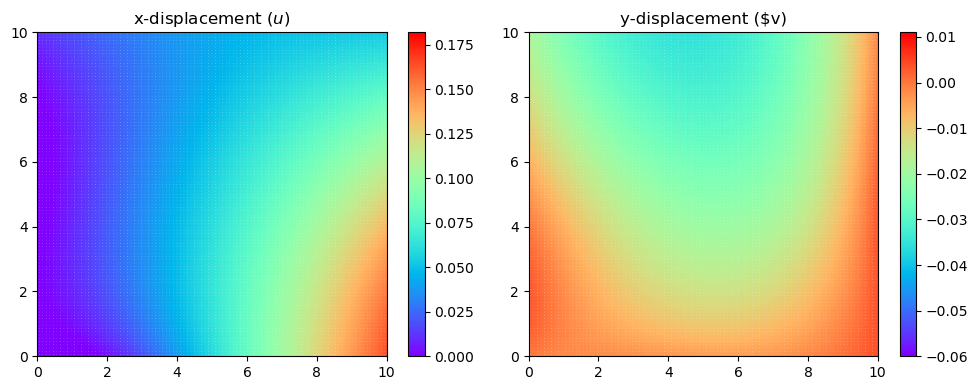

In [14]:
samples = geom.uniform_points(10000)
pde_disp = model.predict(samples)

plt.figure(figsize=(10, 4))
for idx in range(2):
    plt.subplot(1, 2, idx+1)
    plt.scatter(samples[:, 0], samples[:, 1], c=pde_disp[:, idx], cmap='rainbow', s=5)
    plt.clim(color_legend[idx])
    plt.title(title[idx])
    plt.xlim([0, a])
    plt.ylim([0, b])
    plt.colorbar()
plt.tight_layout()
plt.show()

### 1.3.7 Train More (L-BFGS Optimizer)

Compiling model...
'compile' took 0.003483 s

Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
11000     [2.56e-06, 1.66e-06, 1.11e-06, 6.83e-07, 4.52e-07, 1.93e-07, 3.29e-07, 1.50e-07]    [1.87e-06, 8.85e-07, 1.11e-06, 6.83e-07, 4.52e-07, 1.93e-07, 3.29e-07, 1.50e-07]    []  
12000     [2.55e-06, 1.65e-06, 1.11e-06, 6.83e-07, 4.55e-07, 1.91e-07, 3.28e-07, 1.45e-07]    [1.86e-06, 8.88e-07, 1.11e-06, 6.83e-07, 4.55e-07, 1.91e-07, 3.28e-07, 1.45e-07]    []  
13000     [2.55e-06, 1.65e-06, 1.11e-06, 6.82e-07, 4.56e-07, 1.91e-07, 3.27e-07, 1.45e-07]    [1.85e-06, 8.88e-07, 1.11e-06, 6.82e-07, 4.56e-07, 1.91e-07, 3.27e-07, 1.45e-07]    []  

Best model at step 13000:
  train loss: 7.12e-06
  test loss: 5.65e-06
  test metric: []

'train' took 64.983805 s



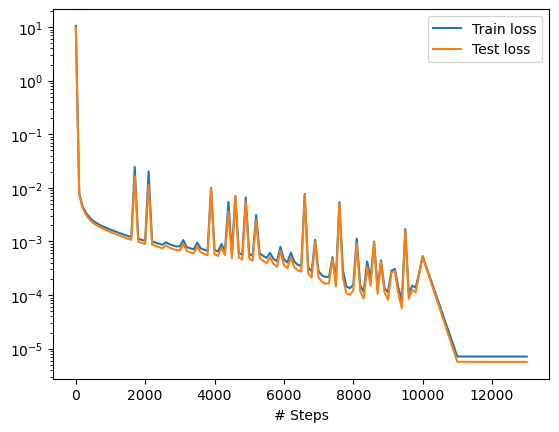

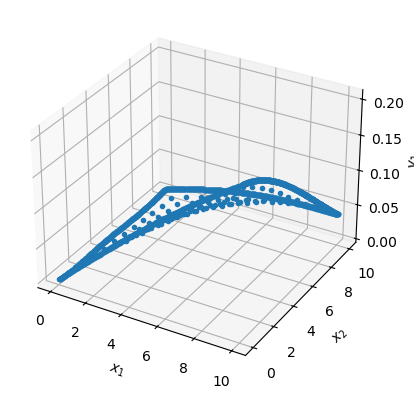

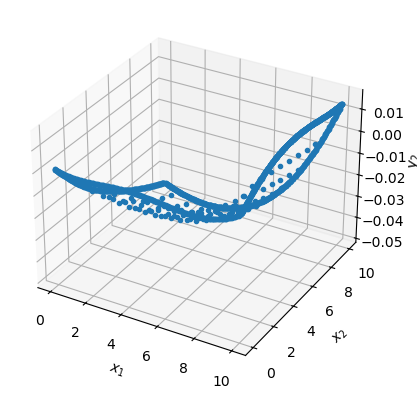

In [16]:
dde.optimizers.config.set_LBFGS_options(maxiter=3000)
model.compile('L-BFGS')
loss_history, train_state = model.train()
dde.saveplot(loss_history, train_state, issave=False, isplot=True)

### 1.3.8 Plot Displacement (Adam + L-BFGS)

In [17]:
color_legend = [[0, 0.182], [-0.06, 0.011], [-0.0022, 1.0], [-0.15, 0.45]]
title = ['x-displacement ($u$)', 'y-displacement ($v)', '$\sigma_{xx}$', '$\sigma_{yy}$']

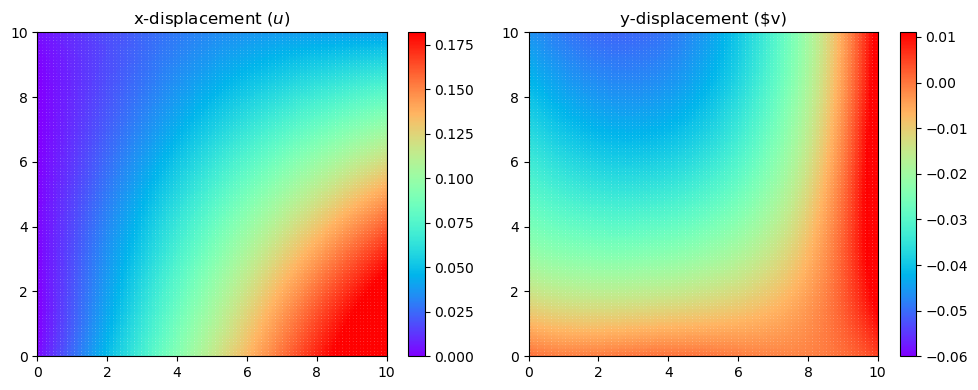

In [18]:
samples = geom.uniform_points(10000)
pde_disp = model.predict(samples)

plt.figure(figsize=(10, 4))
for idx in range(2):
    plt.subplot(1, 2, idx+1)
    plt.scatter(samples[:, 0], samples[:, 1], c=pde_disp[:, idx], cmap='rainbow', s=5)
    plt.clim(color_legend[idx])
    plt.title(title[idx])
    plt.xlim([0, a])
    plt.ylim([0, b])
    plt.colorbar()
plt.tight_layout()
plt.show()